<a href="https://colab.research.google.com/github/peisuke/homography-estimation/blob/main/fundamental_ex9_LoFTR_NGRANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Configure environment and grab LoFTR code.
!git clone https://github.com/zju3dv/LoFTR

Cloning into 'LoFTR'...
remote: Enumerating objects: 396, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 396 (delta 5), reused 2 (delta 0), pack-reused 381
Receiving objects: 100% (396/396), 30.85 MiB | 39.33 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [2]:
!git clone https://github.com/vislearn/ngransac.git

Cloning into 'ngransac'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 63 (delta 1), reused 3 (delta 1), pack-reused 54
Unpacking objects: 100% (63/63), done.


In [3]:
!sed -i '5,9d' /content/ngransac/ngransac/setup.py
!sed -i "5i opencv_lib_dir = '/usr/lib/x86_64-linux-gnu/'" /content/ngransac/ngransac/setup.py
!sed -i "6i opencv_inc_dir = '/usr/include'" /content/ngransac/ngransac/setup.py
!sed -i "7i conda_env = ''" /content/ngransac/ngransac/setup.py

In [4]:
!cd ngransac/ngransac && python setup.py bdist_wheel

running bdist_wheel
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:381: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
running build
running build_ext
building 'ngransac' extension
creating build
creating build/temp.linux-x86_64-3.7
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include -I/usr/local/lib/python3.7/dist-packages/torch/include -I/usr/local/lib/python3.7/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3.7/dist-packages/torch/include/TH -I/usr/

In [5]:
!pip install ngransac/ngransac/dist/ngransac-0.0.0-cp37-cp37m-linux_x86_64.whl

Processing ./ngransac/ngransac/dist/ngransac-0.0.0-cp37-cp37m-linux_x86_64.whl


In [6]:
import torch
import glob
import random
import cv2
import numpy as np
from PIL import Image

In [7]:
import sys
sys.path.append('./ngransac')
sys.path.append('LoFTR')

In [8]:
!pip install torch einops yacs kornia

     |████████████████████████████████| 493 kB 8.4 MB/s 


In [9]:
from src.loftr import LoFTR, default_cfg

In [10]:
from network import CNNet
from dataset import SparseDataset
import util
import ngransac

In [11]:
!mkdir weights 
!cd weights && gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY
To: /content/weights/outdoor_ds.ckpt
100% 46.3M/46.3M [00:00<00:00, 50.2MB/s]


In [12]:
!wget https://raw.githubusercontent.com/peisuke/homography-estimation/main/pair_images.zip

--2022-04-22 07:27:30--  https://raw.githubusercontent.com/peisuke/homography-estimation/main/pair_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1508977 (1.4M) [application/zip]
Saving to: ‘pair_images.zip’

pair_images.zip     100%[===================>]   1.44M  --.-KB/s    in 0.05s   

2022-04-22 07:27:30 (26.5 MB/s) - ‘pair_images.zip’ saved [1508977/1508977]



In [13]:
!cp /content/drive/MyDrive/colab_data/pair_images.zip .
!unzip -q pair_images.zip

cp: cannot stat '/content/drive/MyDrive/colab_data/pair_images.zip': No such file or directory


In [14]:
# loading neural guidence network
ratio = 1.0

model_file = util.create_session_string('e2e', False, False, False, ratio, '')
model_file = 'ngransac/models/weights_' + model_file + '.net'
print(model_file)

ngransac/models/weights_e2e_E_r1.00_.net


In [15]:
resblocks = 12
model = CNNet(resblocks)
model.load_state_dict(torch.load(model_file))
model = model.cuda()
model.eval()
print("Successfully loaded model.")

Successfully loaded model.


In [16]:
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [17]:
def match(img0_raw, img1_raw):
    if len(img0_raw.shape) > 2:
        img0_raw = cv2.cvtColor(img0_raw, cv2.COLOR_BGR2GRAY)
    if len(img1_raw.shape) > 2:
        img1_raw = cv2.cvtColor(img1_raw, cv2.COLOR_BGR2GRAY)

    img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
    batch = {'image0': img0, 'image1': img1}

    # Inference with LoFTR and get prediction
    with torch.no_grad():
        matcher(batch)
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        mconf = batch['mconf'].cpu().numpy()

    kp0 = [cv2.KeyPoint(p[0], p[1], 1) for p in mkpts0]
    kp1 = [cv2.KeyPoint(p[0], p[1], 1) for p in mkpts1]
    good = [cv2.DMatch(i, i, 1) for i in range(len(mkpts0))]

    return kp0, kp1, good

In [18]:
def find_fundamental_mat(kp1, kp2, good, shape1, shape2, model):
    threshold = 5

    pts1 = np.array([kp.pt for kp in kp1])
    pts2 = np.array([kp.pt for kp in kp2])
    ratios = np.ones(len(kp1))
    
    pts1 = np.expand_dims(pts1, 0)
    pts2 = np.expand_dims(pts2, 0)
    util.normalize_pts(pts1, shape1)
    util.normalize_pts(pts2, shape2)

    ratios = np.array([ratios])
    ratios = np.expand_dims(ratios, 2)

    # create data tensor of feature coordinates and matching ratios
    correspondences = np.concatenate((pts1, pts2, ratios), axis=2)
    correspondences = np.transpose(correspondences)
    correspondences = torch.from_numpy(correspondences).float()

    # predict neural guidance, i.e. RANSAC sampling probabilities
    log_probs = model(correspondences.unsqueeze(0).cuda())[0] #zero-indexing creates and removes a dummy batch dimension
    probs = torch.exp(log_probs).cpu()

    out_model = torch.zeros((3, 3)).float() # estimated model
    out_inliers = torch.zeros(log_probs.size()) # inlier mask of estimated model
    out_gradients = torch.zeros(log_probs.size()) # gradient tensor (only used during training)
    rand_seed = 0 # random seed to by used in C++

    # undo normalization of x and y image coordinates
    util.denormalize_pts(correspondences[0:2], img1.shape)
    util.denormalize_pts(correspondences[2:4], img2.shape)

    hyps = 1000
    refine = True
    incount = ngransac.find_fundamental_mat(correspondences, probs, rand_seed, \
                                            hyps, threshold, refine, out_model, out_inliers, out_gradients)
    
    # create a visualization of the matching, comparing results of RANSAC and NG-RANSAC
    out_inliers = out_inliers.byte().numpy().ravel().tolist()

    good2 = [g for g, o in zip(good, out_inliers) if o > 0]
    return good2

LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],
/usr/local/lib/python3.7/dist-packages/tor

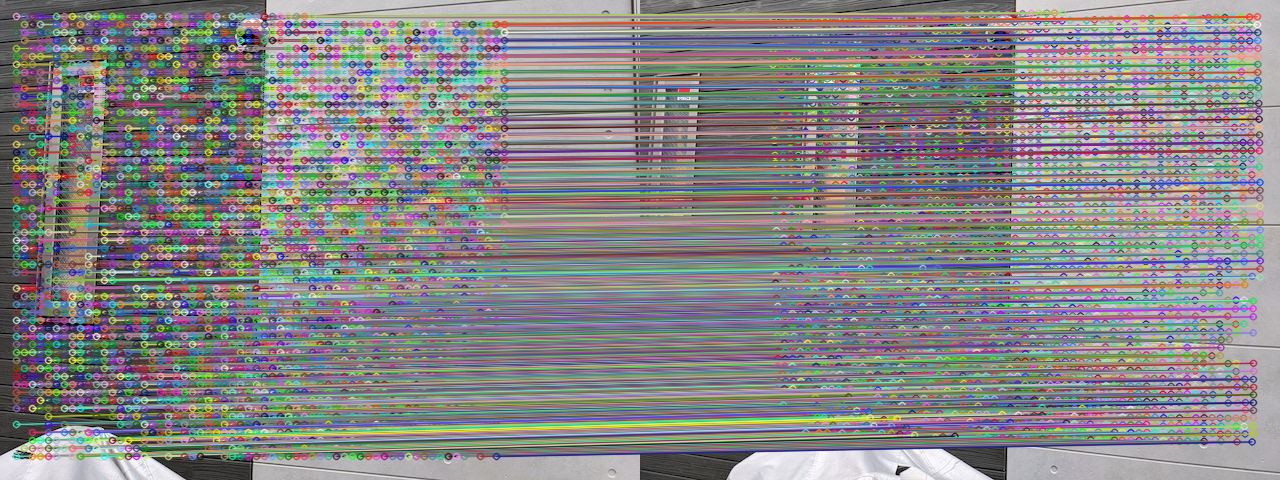

In [19]:
files = sorted(glob.glob('pair_images/pair_01/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
good2 = find_fundamental_mat(kp1, kp2, good, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


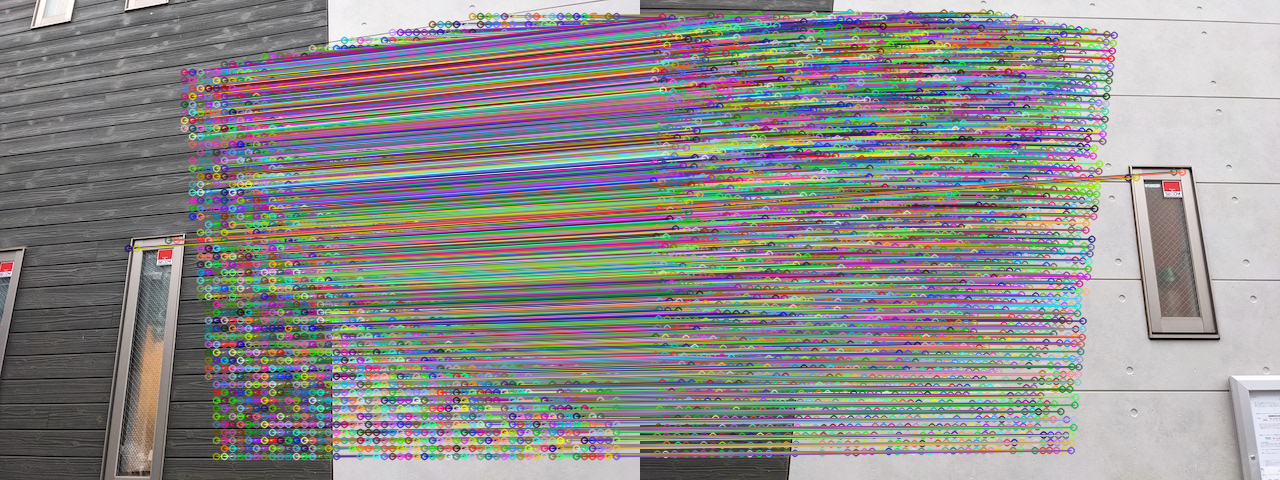

In [20]:
files = sorted(glob.glob('pair_images/pair_02/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
good2 = find_fundamental_mat(kp1, kp2, good, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


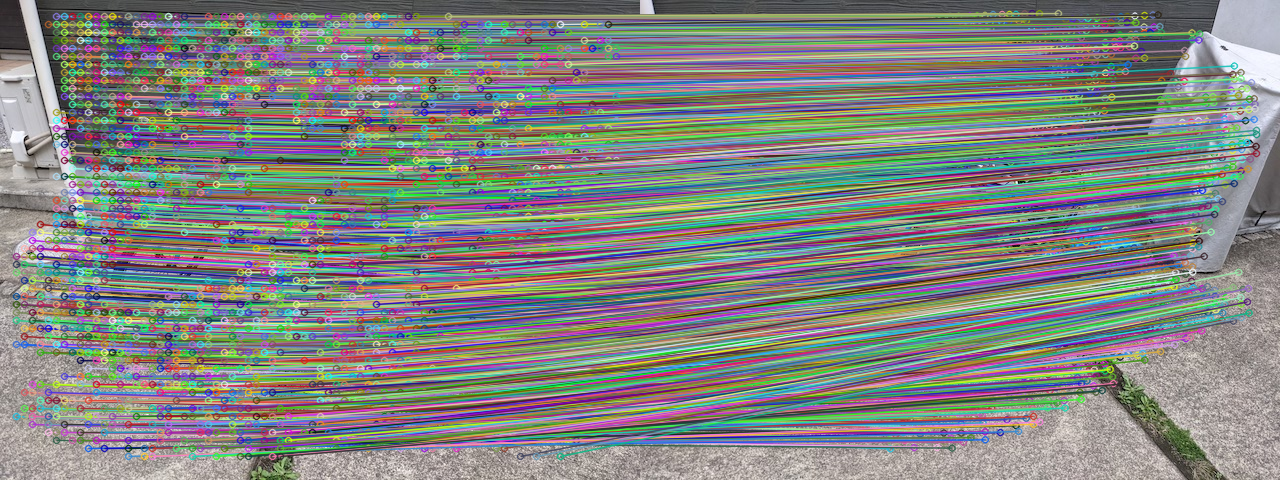

In [21]:
files = sorted(glob.glob('pair_images/pair_03/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
good2 = find_fundamental_mat(kp1, kp2, good, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


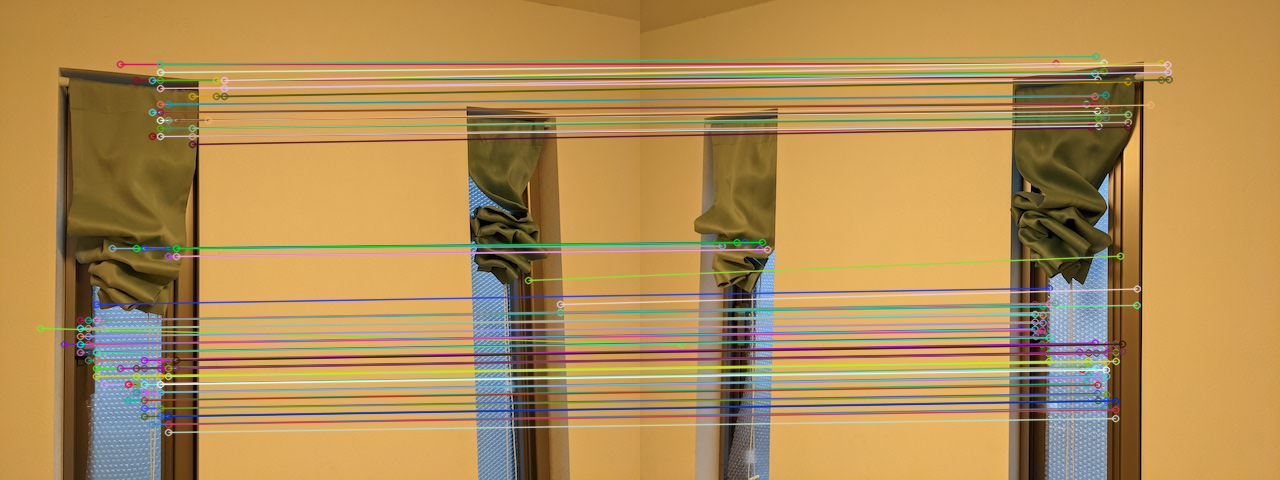

In [22]:
files = sorted(glob.glob('pair_images/pair_04/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
good2 = find_fundamental_mat(kp1, kp2, good, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


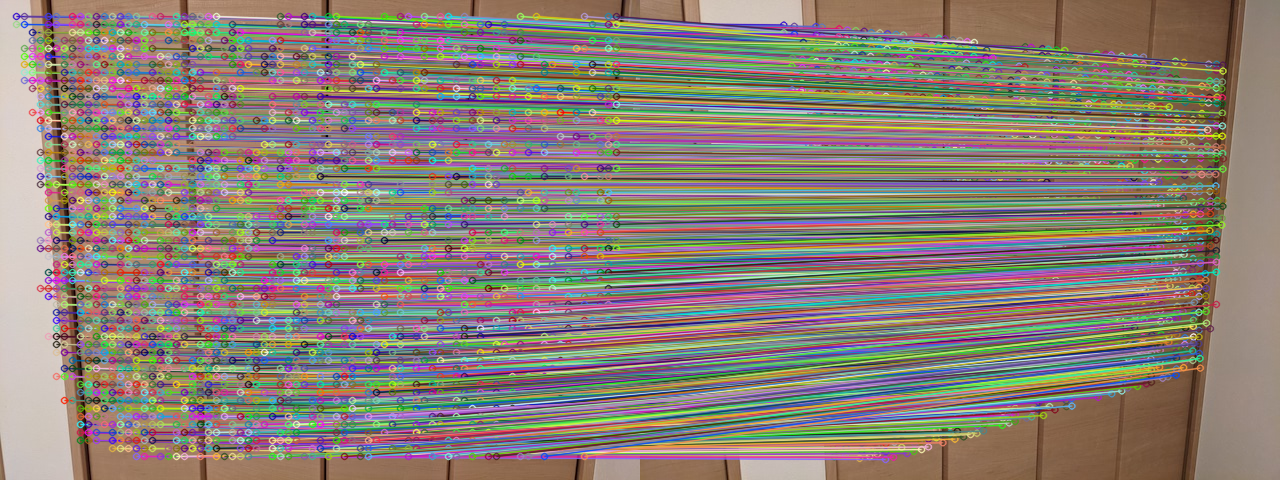

In [23]:
files = sorted(glob.glob('pair_images/pair_05/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
good2 = find_fundamental_mat(kp1, kp2, good, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


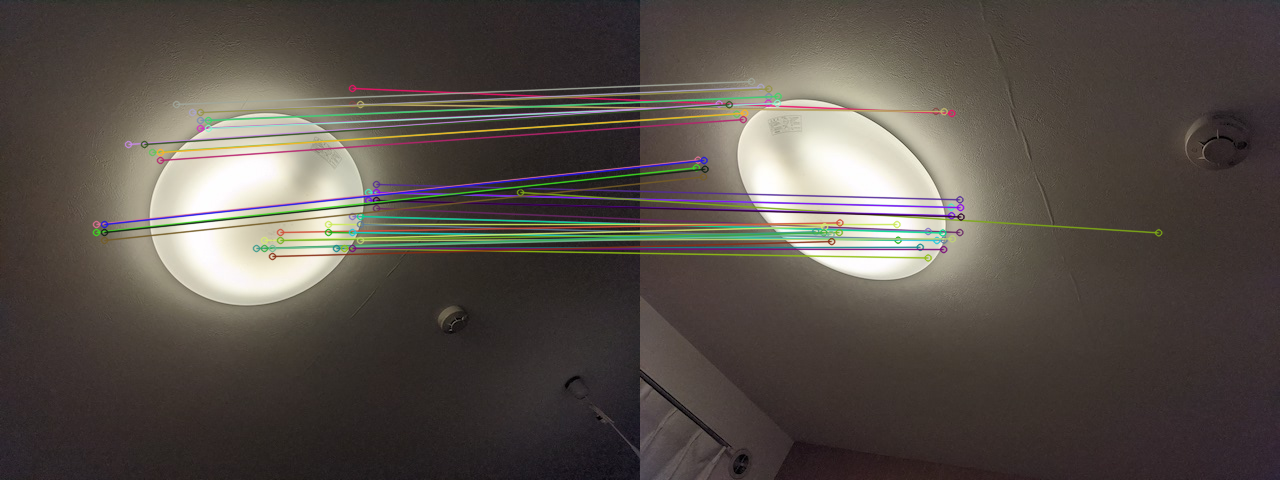

In [24]:
files = sorted(glob.glob('pair_images/pair_06/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
good2 = find_fundamental_mat(kp1, kp2, good, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

LoFTR/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
LoFTR/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


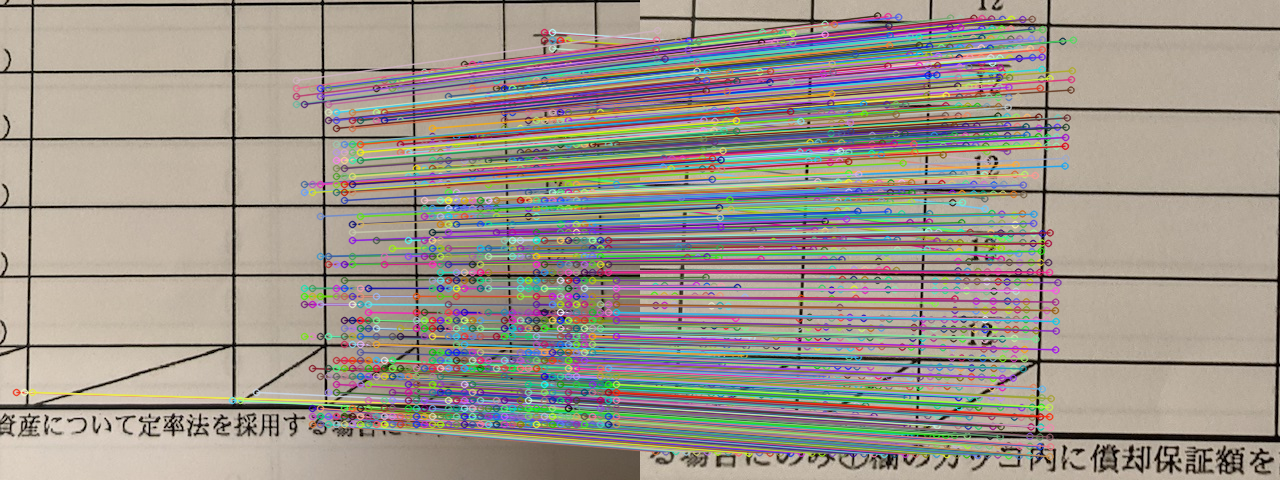

In [25]:
files = sorted(glob.glob('pair_images/pair_07/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (640, 480))
img2 = cv2.resize(cv2.imread(files[1]), (640, 480))

kp1, kp2, good = match(img1, img2)
good2 = find_fundamental_mat(kp1, kp2, good, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))